In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', '..', '..', 'notebook_format'))

from formats import load_style
load_style(css_style='custom2.css', plot_style=False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import os
import torch
import faiss
import random
import transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import sklearn.metrics as metrics
from PIL import Image
from time import perf_counter
from typing import List, Optional
from dataclasses import dataclass
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.model_summary import ModelSummary
from transformers import (
    AutoConfig,
    AutoModel,
    AutoTokenizer,
    AutoImageProcessor
)

# https://discuss.huggingface.co/t/get-using-the-call-method-is-faster-warning-with-datacollatorwithpadding/23924
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'

%watermark -a 'Ethen' -d -u -v -iv

Author: Ethen

Last updated: 2023-11-07

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.13.2

faiss            : 1.7.2
numpy            : 1.23.2
torch            : 2.1.0
matplotlib       : 3.7.1
pandas           : 2.0.1
PIL              : 9.5.0
sklearn          : 1.3.0
transformers     : 4.34.0
pytorch_lightning: 2.1.0



# CLIP (Contrastive Language-Image Pre-training)

Self-supervision, a.k.a. pre-training methods has been all the rage lately. The core idea behind this is supervised learning that has been the main workhorse in machine learning applications requires labeled data. In real world scenarios getting large amounts of labeled data can be very expensive, not to mention we might need to continuously annotate ground truth for new data to ensure our system can adapt to newer information. One of the benefits of self-supervised learning is to reduce the amount of labeling required. Given large amounts of un-labeled data at hand, we would create proxy tasks from the data itself and pre-train our model on them, these tasks are basically turning our un-supervised learning into a supervised learning problem. By warming up our models, the hope is that we can then achieve competitive results on the downstream applications that we are actually interested in by fine-tuning it on a smaller set of labeled data.

In this document, we'll go over one popular vision language pre-training methods called CLIP (Contrastive Language-Image Pre-training) [[6]](https://openai.com/blog/clip/) [[8]](https://arxiv.org/abs/2103.00020). The de-facto approach to a lot of vision tasks in this deep learning era is to start from pretrained visual representations, potentially trained via supervised learning on image classification dataset such as ImageNet. CLIP demonstrated a pre-training task of predicting which caption goes with which image via contrastive loss is an efficient and scalable way to learn SOTA image representations. Directly quoting from the original paper:

> The model transfers non-trivially to most tasks and is often competitive with a fully supervised baseline without the need for any dataset specific training. For instance, we match the accuracy of the original ResNet-50 on ImageNet zero-shot without needing to use any of the 1.28 million training examples it was trained on.

Personally, one of the most interesting things about this method is its multi-modality nature. i.e. there are pure text pre-training models such as BERT or pure image pre-training methods such as SIMCLR, but using natural language supervision to guide image representation learning is definitely quite unique.

The following code skeletion is inspired from [[1]](https://github.com/moein-shariatnia/OpenAI-CLIP) [[4]](https://wandb.ai/manan-goel/coco-clip/reports/Implementing-CLIP-with-PyTorch-Lightning--VmlldzoyMzg4Njk1).

In [3]:
@dataclass
class Config:
    cache_dir: str = "./cache_dir"
    image_dir: str = "./data/flickr30k_images/flickr30k_images"
    captions_path: str = "./data/flickr30k_images/results.csv"
    val_size: float = 0.1
    batch_size: int = 64
    num_workers: int = 4
    seed: int = 42

    lr: float = 0.0001
    weight_decay: float = 0.0005
    epochs: int = 3
    model_checkpoint: Optional[str] = None
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def __post_init__(self):
        random.seed(self.seed)
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed_all(self.seed)


config = Config()

## Dataset

We'll be using publicly available Flickr30k from Kaggle [[7]](https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset) as our example dataset, other dataset choices with reasonable sizes are Flickr8k and MS-COCO Captions.

```bash
# sample command to download the dataset using kaggle API and unzip it
kaggle datasets download -d hsankesara/flickr-image-dataset -p .
unzip flickr-image-dataset.zip
```

Next few code chunks performs the usual of reading in our dataset, creating train/validation split. Read in some sample dataset for manual inspection. One important thing to note about this dataset is each image is paired with multiple captions, 5 to be exact.

In [4]:
def create_train_val_df(captions_path: str, val_size: float):
    df = pd.read_csv(
        captions_path,
        sep="|",
        skiprows=1,
        names=["image", "caption_number", "caption"]
    )
    # indicate these are labeled pairs, useful for calculating
    # offline evaluation metrics
    df["label"] = 1.0
    
    # remove extra white space up front
    df['caption'] = df['caption'].str.lstrip()
    df['caption_number'] = df['caption_number'].str.lstrip()
    # one of the rows is corrupted
    df.loc[19999, 'caption_number'] = "4"
    df.loc[19999, 'caption'] = "A dog runs across the grass ."

    max_id = df.shape[0] // 5
    df["ids"] = [id_ for id_ in range(max_id) for _ in range(5)]

    image_ids = np.arange(0, max_id)
    val_ids = np.random.choice(
        image_ids,
        size=int(val_size * len(image_ids)),
        replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in val_ids]
    df_train = df[df["ids"].isin(train_ids)].reset_index(drop=True)
    df_val = df[df["ids"].isin(val_ids)].reset_index(drop=True)
    return df_train, df_val

In [5]:
df_train, df_val = create_train_val_df(config.captions_path, config.val_size)

# test, distinct images in our validation set
df_test = df_val[df_val["caption_number"] == "0"].reset_index(drop=True)

print("train shape: ", df_train.shape)
print("validation shape: ", df_val.shape)
print("test shape: ", df_test.shape)
df_train.head()

train shape:  (143025, 5)
validation shape:  (15890, 5)
test shape:  (3178, 5)


image caption_number   
0  1000092795.jpg              0  \
1  1000092795.jpg              1   
2  1000092795.jpg              2   
3  1000092795.jpg              3   
4  1000092795.jpg              4   

                                             caption  label  ids  
0  Two young guys with shaggy hair look at their ...    1.0    0  
1  Two young , White males are outside near many ...    1.0    0  
2   Two men in green shirts are standing in a yard .    1.0    0  
3       A man in a blue shirt standing in a garden .    1.0    0  
4            Two friends enjoy time spent together .    1.0    0

Two young guys with shaggy hair look at their hands while hanging out in the yard .


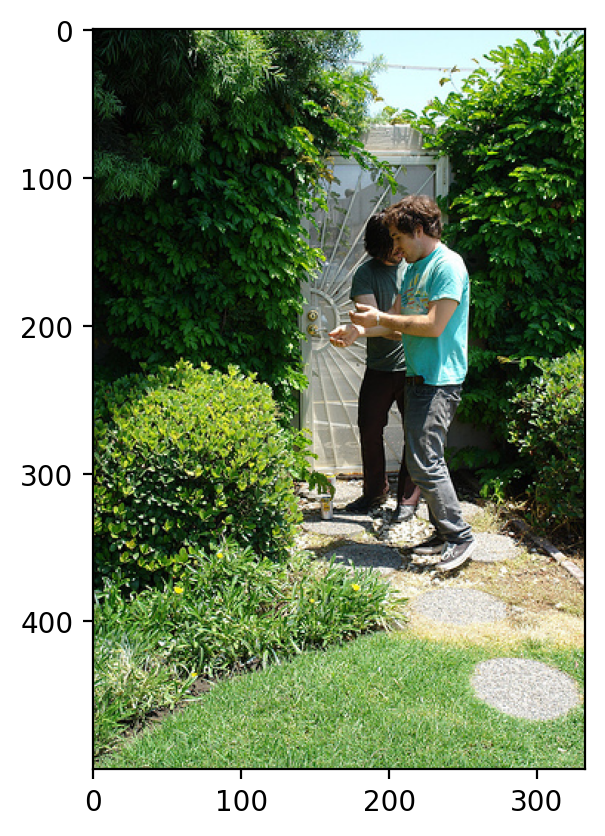

In [6]:
image_file = df_train["image"].iloc[0]
caption = df_train["caption"].iloc[0]
image = Image.open(f"{config.image_dir}/{image_file}")
print(caption)
plt.imshow(image)
plt.show()

We also construct our dataset and dataloader. For data preprocessing, we'll use dataset's `with_transform` method. This applies the transformation only when the examples are accessed, which can be thought of as a lazy version of `map` method.

In [7]:
dataset_dict = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "validation": Dataset.from_pandas(df_val),
    "test": Dataset.from_pandas(df_test)
})
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['image', 'caption_number', 'caption', 'label', 'ids'],
        num_rows: 143025
    })
    validation: Dataset({
        features: ['image', 'caption_number', 'caption', 'label', 'ids'],
        num_rows: 15890
    })
    test: Dataset({
        features: ['image', 'caption_number', 'caption', 'label', 'ids'],
        num_rows: 3178
    })
})

In [8]:
@dataclass
class ClipModelConfig:
    image_encoder_model: str = "google/vit-base-patch16-224-in21k"
    image_embedding_dim: int = 768
    image_size: int = 224
    image_encoder_pretrained: bool = True
    image_encoder_trainable: bool = False

    text_encoder_model: str = "distilbert-base-uncased"
    text_embedding_dim: int = 768
    text_max_length: int = 512
    text_encoder_pretrained: bool = True
    text_encoder_trainable: bool = True

    # projection head
    projection_dim: int = 256 
    dropout: float = 0.1
    # clip loss, whether to normalize embedding
    normalize: bool = True
    # for predicting, generate image or text arm's embedding
    predict_arm: str = "image"

In [9]:
clip_config = ClipModelConfig()
image_processor = AutoImageProcessor.from_pretrained(clip_config.image_encoder_model)
tokenizer = AutoTokenizer.from_pretrained(clip_config.text_encoder_model, use_fast=False)

In [10]:
def transform(batch):
    """
    Each batch contains a text column, as well as path to image. This transformation tokenizes 
    raw text as well as read in the actual image and convert it to pixel values.
    """
    encoded = tokenizer(batch["caption"], truncation=True, max_length=clip_config.text_max_length)

    preprocessed_image = image_processor([Image.open(f"{config.image_dir}/{image}") for image in batch["image"]])
    encoded["pixel_values"] = preprocessed_image["pixel_values"]
    return encoded


dataset_dict_with_transformation = dataset_dict.with_transform(transform)
dataset_dict_with_transformation["train"][0]

{'input_ids': [101,
  2048,
  2402,
  4364,
  2007,
  25741,
  2606,
  2298,
  2012,
  2037,
  2398,
  2096,
  5689,
  2041,
  1999,
  1996,
  4220,
  1012,
  102],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'pixel_values': array([[[-0.9764706 , -0.96862745, -0.9607843 , ...,  0.5058824 ,
           0.7176471 ,  0.7176471 ],
         [-0.9764706 , -0.9607843 , -0.96862745, ...,  0.427451  ,
           0.19215691,  0.4666667 ],
         [-0.9529412 , -0.96862745, -0.9607843 , ..., -0.4588235 ,
          -0.4588235 , -0.17647058],
         ...,
         [-0.38823527, -0.23921567, -0.26274508, ...,  0.06666672,
           0.10588241,  0.05098045],
         [-0.1372549 ,  0.11372554,  0.07450986, ...,  0.14509809,
           0.06666672,  0.12941182],
         [ 0.3411765 ,  0.21568632,  0.00392163, ...,  0.19215691,
           0.21568632,  0.11372554]],
 
        [[-0.9529412 , -0.9529412 , -0.9529412 , ...,  0.77254903,
           0.92941177,  0.9607843

In [11]:
class DataCollatorForClip:
    """Data collator that will dynamically pad the text and image inputs received."""

    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features):
        text_feature = {
            "input_ids": [feature["input_ids"] for feature in features],
            "attention_mask": [feature["attention_mask"] for feature in features]
        }
        batch = self.tokenizer.pad(
            text_feature,
            padding=True,
            return_tensors="pt"
        )
        batch["pixel_values"] = torch.stack([torch.FloatTensor(feature["pixel_values"]) for feature in features])
        return batch

In [12]:
def build_data_loaders(config, dataset, tokenizer, mode):
    data_collator = DataCollatorForClip(tokenizer)
    data_loader = DataLoader(
        dataset,
        batch_size=config.batch_size,
        num_workers=config.num_workers,
        collate_fn=data_collator,
        pin_memory=True,
        shuffle=True if mode == "train" else False
    )
    return data_loader

In [13]:
data_loader_train = build_data_loaders(config, dataset_dict_with_transformation["train"], tokenizer, mode="train")
data_loader_val = build_data_loaders(config, dataset_dict_with_transformation["validation"], tokenizer, mode="validation")
data_loader_test = build_data_loaders(config, dataset_dict_with_transformation["test"], tokenizer, mode="test")

batch = next(iter(data_loader_train))
print("text shape: ", batch["input_ids"].shape)
print("image shape: ", batch["pixel_values"].shape)

text shape:  torch.Size([64, 31])
image shape:  torch.Size([64, 3, 224, 224])


## CLIP Model

CLIP model comprises of three components [[6]](https://openai.com/blog/clip/) [[8]](https://arxiv.org/abs/2103.00020): image encoder, text encoder and projection head (absorbed inside encoder block in the diagram).

<img src="imgs/clip_contrastive_pretraining.png" width="50%" height="50%">

During training we'll need to feed our batches of text and images through its own respective encoder. Given a batch of $n$ text, image pairs, $\text{text}_i, \text{image}_i$, CLIP is trained to predict which of the $n × n$ possible (image, text) pairings across a batch actually occurred. To do this, CLIP learns a multi-modal embedding space by jointly training an image encoder and text encoder to maximize the $N$ real image and text embedding pairs' (cosine) similarity in a given batch while minimizing cosine similarity of $n^2 − n$ incorrect image and text embedding pairings. This is commonly referred to as InfoNCE loss.

\begin{align}
L = -\frac{1}{n} \sum^n_{i=1} \frac{exp(sim(\text{text}_i, \text{image}_i))}{\sum_j exp(sim(\text{text}_i, \text{image}_j))}
\end{align}

Where $sim$ is a similarity function such as cosine similarity or dot product that aims to align embeddings of similar pairs. This loss function can then be treated as a mult-class classification task using cross entropy loss, with the difference that number of class here will be the number of negatives within that batch instead of distinct number of classes that we wish to predict in a multi-class classification problem.

- We load image encoder and text encoder from huggingface `transformers`. Here we will be implementing the clip components ourselves, but huggingface `transformers` also has a [clip implementation](https://huggingface.co/docs/transformers/main/en/model_doc/clip) which can serve as a reference.
- Projection head is responsible for taking both image and text encodings and embedding them into the same dimensional space.
- Feel free to experiment with different image or text encoders, as well as projection head.

Some of other key learnings from the work includes:

- Data: One key ingredients of pre-training is large scale data. CLIP collected a new dataset comprised of 400 million image text pairs from public internet.
- Objective: Choosing proxy task that is training efficient was also key to scaling learning image representations via natural language supervision. As illustrated in this document, CLIP chose a two tower contrastive learning approach of aligning which text as a whole is paired with which image, instead of predictive objective such as predicting exact words of that caption or generative models.
- Encoder: We can always experiment with different encoder architectures, authors reported a 3x gain in compute efficiency by adopting vision transformer over a standard ResNet for image encoder, and found that this model is less sensitive to the text encoder's capacity. They also reported using a higher 336 pixel resolution for images. 
- Training Recipe:
    - Important thing to note is that their contrastive loss uses a very large minibatch size of 32,768, and the calculation of embedding similarities are sharded with individual GPUs.
    - Their largest Vision Transformer took 12 days on 256 V100 GPUs.
    - They train CLIP model completely from scratch without initializing image or text encoder with pre-trained weights.
- Zero Shot Capabilties: Given CLIP leverages natural langauge supervision, this enables far stronger generalization and zero shot capabilities. e.g. Given a task of classifying photos of objects, we can check each image whether CLIP predicts which of the caption "a photo of a dog" or "a photo of a car", etc. is more likely to be paired with it (depicted in the diagram below). We can imagine swapping out the dog and car part with any other class in our prompt making this applicable to potentially arbitrary classification tasks. Caveat: this may require trail and error "prompt engineering" to work well, and still has poor generalization to images not covered in its pre-training dataset.
- Transfer Learning: CLIP's vision encoder which is trained on noisy image-text pairs from the web also offers very solid fine-tuning performance on image classification tasks with the right choice of hyperparameters [[11]](https://arxiv.org/abs/2212.06138).
    - Smaller learning rate.
    - Exponential moving average: keeping a moving average of all model parameters' weight.
    - Layer wise learning rate decay: setting different learning rates for each backbone layer. Top layers have higher learning rate to adapt to new tasks, while bottom layers have smaller learning rate so strong features learned from pre-training is preserved).
    - Data Augmentation: Removing strong random augmentation such as mixup, cutmix.

<img src="imgs/clip_zero_shot.png" width="60%" height="60%">


Apart from CLIP, we'll also use this opportuniy to introduce LiT, a potentially more efficient way of training text-image with contrastive learning. As well as VIT, the image encoder that we'll be using.

### LiT

Locked image text Tuning, LiT [[9]](https://arxiv.org/abs/2111.07991) finds applying contrastive learning using a locked/frozen pre-trained image model with unlocked text model works extremely well. The core idea behind this is to teach a text model to read out good representation from a pre-trained image model.

Image pre-trained models are typically trained on semi-manually labeled images such as ImageNet-21k, which offers high quality data. This approach, however, has a limitation as it's confined to a pre-defined set of categories, restricting the model's generalization capability. In contrast, contrastive learning is often trained on image and text pairs that are loosely aligned from the web. This circumvent the need for manual labeling, and allows for learning richer visual concepts that goes beyond categories that are defined in the classification label space. Initializing contrastive pre-training with an image model that has been pre-trained using cleaner semi-manually labeled dataset aims to provides the best of both worlds: strong image representations from pre-training, plus flexible zero-shot transfer to new tasks via contrastive learning.

- Reduced compute and data requirements. LiT re-uses existing pre-trained image encoders, amortizing computation and data resources to achieve solid performance. Authors from the paper quoted, LiT models trained on 24 million publicly available image-text pairs can rival the zero-shot classification performance of previous models trained on 400 million image-text pairs from private sources.
- Locked/frozen image encoder leads to faster training and a smaller memory footprint. Enabling larger batch sizes, hence improving model's performance in contrastive learning setting.
- Generalization. Locking the image tower improves generalization as it produces a text model that is well aligned to an already strong and general image representation, as opposed to an image text model that is well aligned but specialized to the dataset used for alignment.

### ViT

Transformer/BERT style model was originally proposed in natural language domain, and quickly became the de facto standard model architecture. Its reach into computer vision field came much later, where vision transformers (ViT) [[10]](https://arxiv.org/abs/2010.11929) showed that a pure transformer applied to suquence of image patches is capable of achieving remarkable results for computer vision tasks. We'll elaborate upon its architecture and performance.

Architecture:

<img src="imgs/vit.png" width="60%" height="60%">

The main modification ViT made was show images are fed to a Transformer. Compared to natural language domain where we first tokenized input text before feeding these tokenized ids through our transformer module, for image, we would convert an image into square sized non-overlapping spatches, each of which gets turned into a vector/patch embedding. In the architecture diagram above, this is referred to as linear projection, and in practice these patch embedding are often times generated via convolutional 2D layer. e.g. If we have a 224x224 pixel images, we would end put with a suquence of 196 16x16 flattened image patches. This is why in public pre-trained models, e.g. `google/vit-base-patch16-224-in21k`, we'll see information such as `patch16-224` indicating the patch size as well as image resolution in which it was pre-trained on. Another example is `ViT-B/16` indicating it's a base model trained on 16x16 input patch size. Reason behind this patching is directly applying transformer's self attention to image would require each pixel attending to every other pixel. Given self attention quadratic cost, this does not scale to realistic input sizes.
After this preprocessing, there's a special `[CLS]` token added to the beginning of patch embedding, which can be used as embedding input for downstream task. As well as a learnable position embedding. Both of these are similar to BERT.

Performance:

<img src="imgs/vit_performance.png" width="40%" height="40%">

The main takeaway from this figure is compared to Convolutional Neural Networks (CNN), ViT benefits more from a larger scale pre-trainining data. By scaling from ImageNet 2012 with 1k classes, 1.3M images, to ImageNet-21k with 21k classes and 14M images, as well as private JFT with 18k classes and 300M images, larger ViT models start to dominate other variants from a performance standpoint. This result is also commonly attributed to fundamental differences in how these two types of model process visual information and compared to CNN that are widely used for vision tasks, ViT lack useful inductive biases.

CNN:

- CNNs are designed specifically for processing grid-structured data, such as images. They have a strong locality bias which assumes pixels close to each other in the input image are more related and share information. This is why CNNs use convolutional layers that slide small filters (kernels) over input images to capture local patterns.
- CNNs leverage the translation equivariance property, which means that if a feature (e.g., an edge or a texture) is important in one part of an image, it is likely to be important in other parts as well. This bias is essential for image recognition tasks.

ViT

- ViT aims to preserve the original transformer module without modification to the core self attention operation. The only place where image specific inductive bias are introduced is projecting image to patch embedding as well as when performing fine tuning on higher resolution images (2D interpolation for pre-trained position embedding).
- Transformer were originally designed for sequential data such as text. By treating image as a sequence of image patches, and processing them through self attention mechanisms, they are more flexible in how they capture patterns within images.
- The experiment result reinforces our intuition that convolutional inductive bias is useful for smaller datasets, but for larger ones, learning the relevant patterns directly from global context is sufficient, even beneficial.
- Note,  different from BERT, which relied on self-supervised pre-training via masked language modeling (predicting masked tokens), the original ViT is still based on supervised pre-training.

Other notable learnings at the time includes:

- Unlike in NLP domain, where self-supervised pre-training were employed. In the original ViT work, the best result was still obtained via supervised pre-training.
- Compared to pre-training, we can use a higher image resolution during fine-tuning. When doing so, 2D interpolation is needed to adjust the positional embedding.

### Implementation

In [14]:
class ProjectionHead(nn.Module):

    def __init__(
        self,
        embedding_dim,
        projection_dim,
        dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [15]:
class ImageEncoder(nn.Module):

    def __init__(
        self, model_name, pretrained, trainable, embedding_dim, projection_dim, dropout, normalize
    ):
        super().__init__()
        if pretrained:
            self.model = AutoModel.from_pretrained(model_name)
        else:
            config = AutoConfig.from_pretrained(model_name)
            self.model = AutoModel.from_config(config)

        for p in self.model.parameters():
            p.requires_grad = trainable

        self.projection = ProjectionHead(embedding_dim, projection_dim, dropout)
        self.normalize = normalize

    def forward(self, pixel_values):
        output = self.model(pixel_values)

        # we are using CLS token hidden representation as sentence's embedding
        image_feature = output.last_hidden_state[:, 0, :]
        image_embedding = self.projection(image_feature)
        if self.normalize:
            image_embedding = F.normalize(image_embedding, p=2, dim=1)
        return image_embedding

In [16]:
image_encoder = ImageEncoder(
    model_name=clip_config.image_encoder_model,
    pretrained=clip_config.image_encoder_pretrained,
    trainable=clip_config.image_encoder_trainable,
    embedding_dim=clip_config.image_embedding_dim,
    projection_dim=clip_config.projection_dim,
    dropout=clip_config.dropout,
    normalize=clip_config.normalize
)

In [17]:
image_embedding = image_encoder(batch["pixel_values"])
image_embedding.shape

torch.Size([64, 256])

In [18]:
class TextEncoder(nn.Module):

    def __init__(
        self, model_name, pretrained, trainable, embedding_dim, projection_dim, dropout, normalize
    ):
        super().__init__()
        if pretrained:
            self.model = AutoModel.from_pretrained(model_name)
        else:
            config = AutoConfig.from_pretrained(model_name)
            self.model = AutoModel.from_config(config)

        for p in self.model.parameters():
            p.requires_grad = trainable

        self.projection = ProjectionHead(embedding_dim, projection_dim, dropout)
        self.normalize = normalize

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)

        # we are using CLS token hidden representation as sentence's embedding
        text_feature = output.last_hidden_state[:, 0, :]
        text_embedding = self.projection(text_feature)
        if self.normalize:
            text_embedding = F.normalize(text_embedding, p=2, dim=1)
        return text_embedding

In [19]:
text_encoder = TextEncoder(
    model_name=clip_config.text_encoder_model,
    pretrained=clip_config.text_encoder_pretrained,
    trainable=clip_config.text_encoder_trainable,
    embedding_dim=clip_config.text_embedding_dim,
    projection_dim=clip_config.projection_dim,
    dropout=clip_config.dropout,
    normalize=clip_config.normalize
)

In [20]:
text_embedding = text_encoder(batch["input_ids"], batch["attention_mask"])
text_embedding.shape

torch.Size([64, 256])

Upon confirming both our image and text encoder returns an embedding of the same shape, we can now assemble the clip model.

In [21]:
class ClipModel(pl.LightningModule):

    def __init__(self, config: ClipModelConfig):
        super().__init__()
        self.config = config

        self.image_encoder = ImageEncoder(
            model_name=config.image_encoder_model,
            pretrained=config.image_encoder_pretrained,
            trainable=config.image_encoder_trainable,
            embedding_dim=config.image_embedding_dim,
            projection_dim=config.projection_dim,
            dropout=config.dropout,
            normalize=config.normalize
        )
        self.text_encoder = TextEncoder(
            model_name=config.text_encoder_model,
            pretrained=config.text_encoder_pretrained,
            trainable=config.text_encoder_trainable,
            embedding_dim=config.text_embedding_dim,
            projection_dim=config.projection_dim,
            dropout=config.dropout,
            normalize=config.normalize
        )
        # this trainable temperature value is based on open clip
        # https://github.com/mlfoundations/open_clip/blob/4b929357093bfbb0986b61cfa23776f1dc740370/src/open_clip/model.py
        self.temperature = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.save_hyperparameters()

    def forward(self, batch):
        # Getting text and image embedding (with same dimension)
        text_embedding = self.text_encoder(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )
        image_embedding = self.image_encoder(batch["pixel_values"])
        return text_embedding, image_embedding

    def _compute_loss(self, text_embedding, image_embedding):
        # @ is equivalent to torch.mm, calculating similarity between text
        # and image embedding
        logits = (text_embedding @ image_embedding.T) * self.temperature.exp()
        targets = torch.arange(logits.shape[0], device=config.device, dtype=torch.long)
        text_loss = F.cross_entropy(logits, targets, reduction="none")
        image_loss = F.cross_entropy(logits.T, targets, reduction="none")
        loss = (image_loss + text_loss) / 2.0
        return loss.mean()

    def training_step(self, batch, batch_idx):
        text_embedding, image_embedding = self.forward(batch)
        loss = self._compute_loss(text_embedding, image_embedding)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        text_embedding, image_embedding = self.forward(batch)
        loss = self._compute_loss(text_embedding, image_embedding)
        self.log("validation_loss", loss, prog_bar=True)
        return loss

    def predict_step(self, batch, batch_idx):
        if self.config.predict_arm == "text":
            return self.text_encoder(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
        elif self.config.predict_arm == "image":
            return self.image_encoder(batch["pixel_values"])

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=config.lr,
            weight_decay=config.weight_decay
        )
        return optimizer

In [22]:
clip_model = ClipModel(clip_config)
trainer = pl.Trainer(
    accelerator="gpu",
    devices=-1,
    max_epochs=config.epochs,
    precision="16-mixed",
    # note, we purpose-fully disabled the progress bar to prevent flooding our notebook's console
    # in normal settings, we can/should definitely turn it on
    enable_progress_bar=False,
    log_every_n_steps=500,
    # skip validation
    # val_check_interval=None,
    # check_val_every_n_epoch=config.epochs + 1
)
if not config.model_checkpoint:
    t1_start = perf_counter()
    trainer.fit(clip_model, data_loader_train, data_loader_val)
    t1_stop = perf_counter()
    print("Training elapsed time:", t1_stop - t1_start)
    clip_model = ClipModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
else:
    clip_model = ClipModel.load_from_checkpoint(config.model_checkpoint)
    ModelSummary(clip_model, max_depth=1)

# set to evaluation after training, we'll be doing inferencing in the next section
clip_model.to(config.device)
clip_model.eval()

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type         | Params
-----------------------------------------------
0 | image_encoder | ImageEncoder | 86.7 M
1 | text_encoder  | TextEncoder  | 66.6 M
  | other params  | n/a          | 1     
-----------------------------------------------
66.9 M    Trainable params
86.4 M    Non-trainable params
153 M     Total params
613.114   Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=3` reached.


Training elapsed time: 1625.0015170039997


ClipModel(
  (image_encoder): ImageEncoder(
    (model): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (intermed

## Evaluation

For evaluation, we'll conduct adhoc qualitative analysis by feeding our model a piece of input text and showing the top-k retrieved images as well as perform quantitative evaluation by computing retrieval recall@k and let actual numbers speak to our model's quality. For retrieving top-k results, we'll be using faiss for computing exact cosine similarity between text and image embeddings.

In [23]:
t1_start = perf_counter()
clip_model.config.predict_arm = "image"
image_embeddings = trainer.predict(clip_model, data_loader_test)
image_embeddings = torch.cat(image_embeddings)

clip_model.config.predict_arm = "text"
text_embeddings = trainer.predict(clip_model, data_loader_test)
text_embeddings = torch.cat(text_embeddings)
t1_stop = perf_counter()
print("embedding prediction elapsed time:", t1_stop - t1_start)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


embedding prediction elapsed time: 23.795321758000682


In [24]:
def build_faiss_index_with_ids(index_ids: str, index_embeddings: str) -> faiss.IndexIDMap:
    """
    This leverages faiss's IndexIDMap type index, which
    allows end-user to supply a long type (64 bit) id in additional to vectors.
    The benefit this brings is at search time, this index will return the stored ids
    rather than the default sequential ids.
    """
    # input embeddings are already normalized, inner product is equivalent to cosine similarity
    faiss_index = faiss.IndexFlatIP(index_embeddings.shape[1])
    faiss_index = faiss.index_cpu_to_all_gpus(faiss_index)
    faiss_index = faiss.IndexIDMap(faiss_index)
    faiss_index.add_with_ids(index_embeddings, index_ids)

    print(f"embedding dimension: {index_embeddings.shape[1]}")
    print(f"faiss index size: {faiss_index.ntotal}")
    return faiss_index

In [25]:
faiss_index = build_faiss_index_with_ids(df_test["ids"].values, np.array(image_embeddings))

embedding dimension: 256
faiss index size: 3178


In [26]:
def find_matches(
    clip_model,
    faiss_index,
    query,
    id_to_image
):
    """
    computing top-k cosine similarity between
    input query and all of our image embeddings.
    """
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_embeddings = clip_model.text_encoder(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

    # For each input query (row), the top k result's distance/score and index (column)
    scores, indices = faiss_index.search(np.array(text_embeddings), k=9)
    matches = [id_to_image[index] for index in indices[0]]

    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = Image.open(f"{config.image_dir}/{match}")
        ax.imshow(image)
        ax.axis("off")

    plt.show()

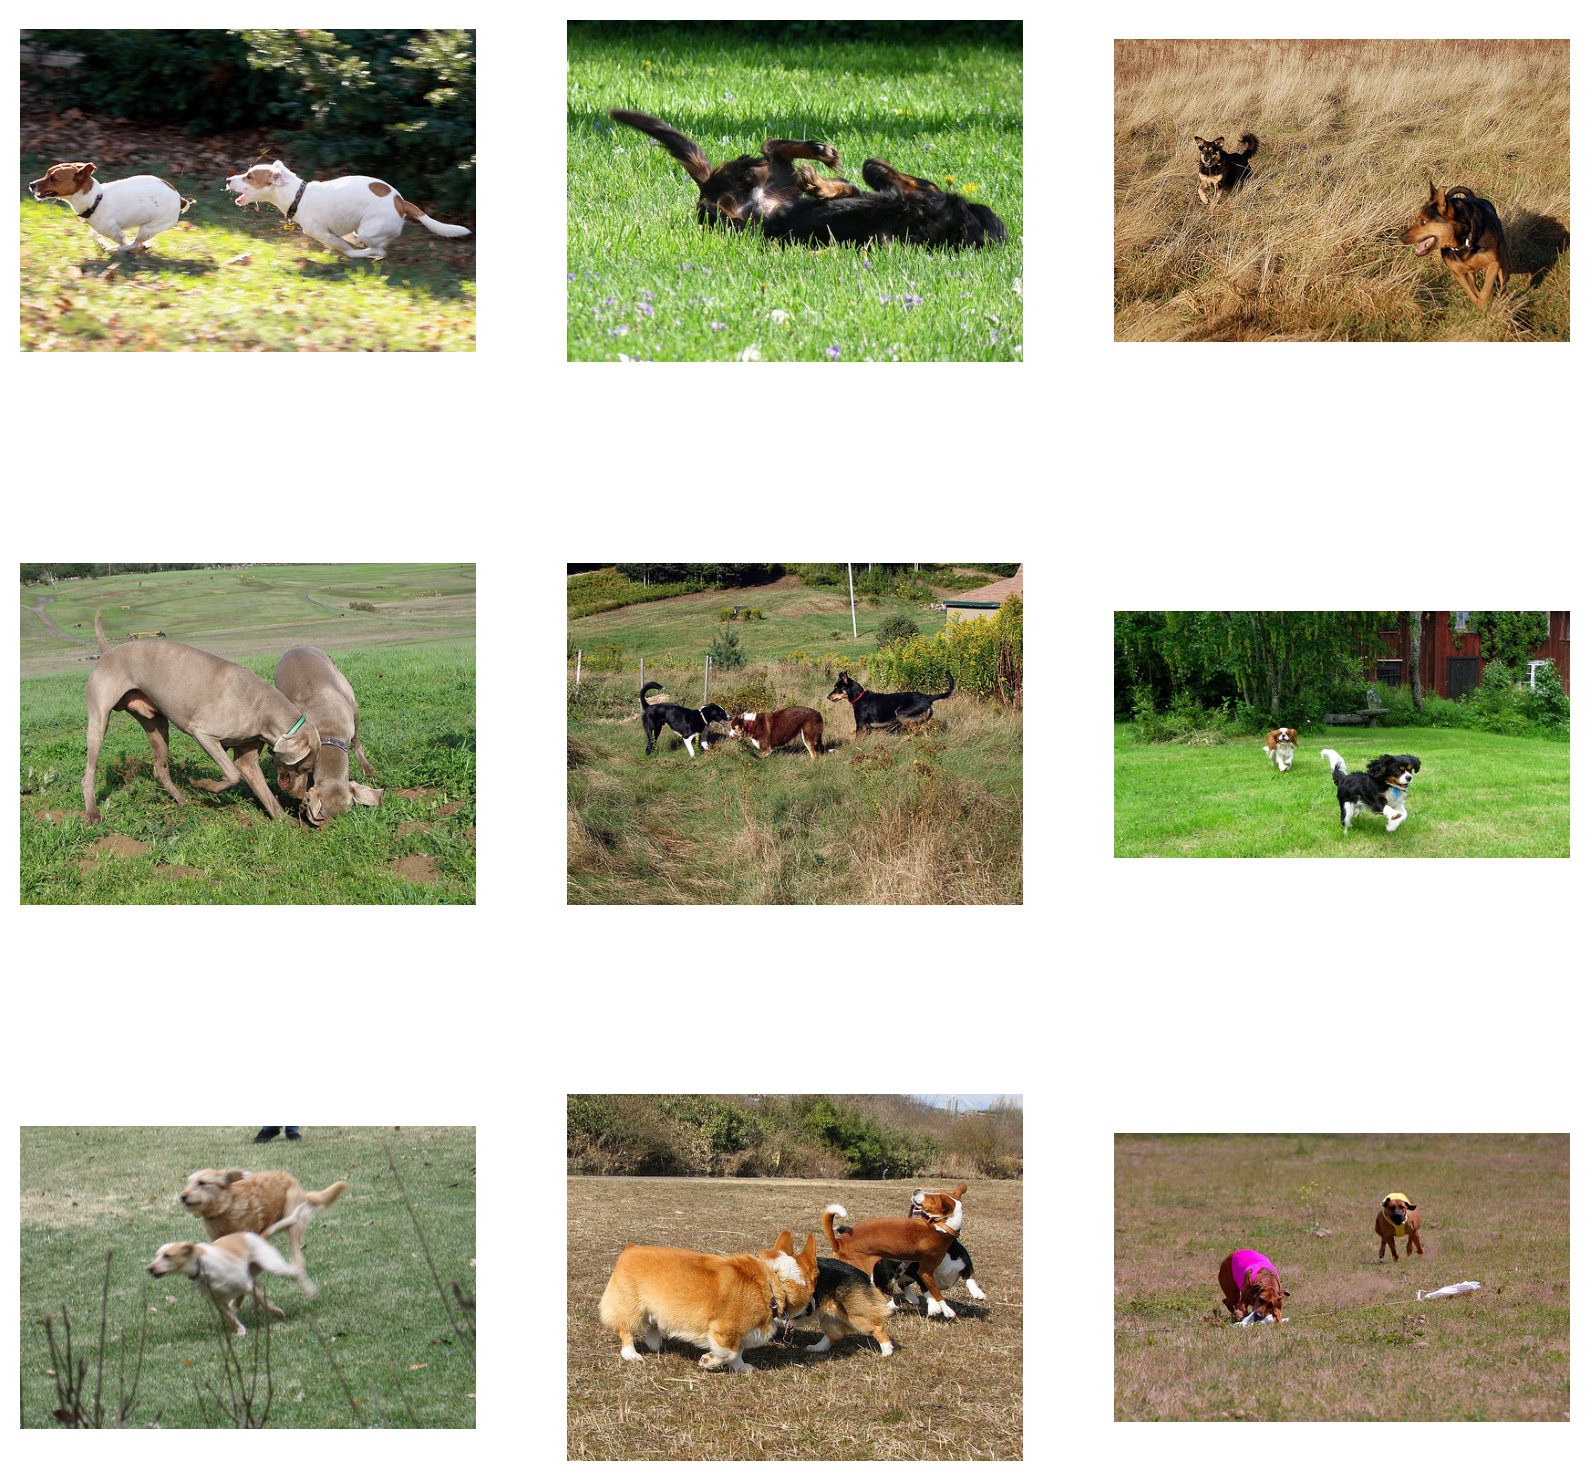

In [27]:
query = "dogs on the grass"
id_to_image = dict(zip(df_test["ids"], df_test["image"]))
find_matches(clip_model, faiss_index, query, id_to_image)

In [28]:
def flatten_nn_data(
    scores,
    indices,
    df_query: pd.DataFrame,
    query_id_column_name: str,
    index_id_column_name: str
) -> pd.DataFrame:
    """
    Flatten the knn-searched score/index with original query and generate a single dataframe.
    That looks like the following:

    ```
    	query	score	    index	rank	prediction
    0	query1	0.845458    112421	1	    1
    1	query1	0.842927    105703	2	    1
    2	query1	0.842927    89698	3	    1
    3	query1	0.840206    26245	4	    1
    4	query1	0.834274    70360	5	    1
    ```
    """

    k = scores.shape[1]
    query_list = []
    index_list = []
    score_list = []
    rank_list = []
    for idx, query in enumerate(df_query[query_id_column_name]):
        query_list.extend([query] * k)
        index_list.extend(indices[idx])
        score_list.extend(scores[idx])
        rank_list.extend(range(1, k + 1))

    df_prediction_flat = pd.DataFrame({
        query_id_column_name: query_list,
        index_id_column_name: index_list,
        "score": score_list,
        "rank": rank_list
    })
    df_prediction_flat["prediction"] = 1
    return df_prediction_flat


def compute_metrics(
    df_eval_input: pd.DataFrame,
    df_label: pd.DataFrame,
    query_id_column_name: str,
    index_id_column_name: str,
    k_candidates: List[int]
) -> pd.DataFrame:
    """Given the retrieval result and golden label dataset, compute recall@k metrics

    This generates the following dataframe

    ```
    	recall
     5	0.3792
    10	0.5039
    20	0.6257
    ```
    """
    recall_list = []
    for k in k_candidates:        
        df_eval_input_at_k = (
            df_eval_input[df_eval_input["rank"] <= k]
            # merge with label
            .merge(df_label, on=[query_id_column_name, index_id_column_name], how="outer")
            .fillna({"prediction": 0, "label": 0})
        )
        recall = metrics.recall_score(
            df_eval_input_at_k["label"],
            df_eval_input_at_k["prediction"]
        )
        recall_list.append(recall)

    df_metrics = pd.DataFrame({
        "recall": np.round(recall_list, 4)
    }, index=k_candidates)
    return df_metrics

In [29]:
scores, indices = faiss_index.search(np.array(text_embeddings), k=20)
df_eval_input = flatten_nn_data(
    scores,
    indices,
    df_test,
    query_id_column_name="caption",
    index_id_column_name="ids"
)
df_eval_input

caption    ids     score   
0      A man sits in a chair while holding a large st...      6  0.471433  \
1      A man sits in a chair while holding a large st...  16992  0.372528   
2      A man sits in a chair while holding a large st...   8769  0.366039   
3      A man sits in a chair while holding a large st...  13274  0.361954   
4      A man sits in a chair while holding a large st...    621  0.359687   
...                                                  ...    ...       ...   
63555  People standing around laughing at a woman sit...  11990  0.433577   
63556  People standing around laughing at a woman sit...  20471  0.432437   
63557  People standing around laughing at a woman sit...   1448  0.431907   
63558  People standing around laughing at a woman sit...  15820  0.428830   
63559  People standing around laughing at a woman sit...   6551  0.419095   

       rank  prediction  
0         1           1  
1         2           1  
2         3           1  
3         4           1  
4         5           1  
...     ...         ...  
63555    16           1  
63556    17           1  
63557    18           1  
63558    19           1  
63559    20           1  

[63560 rows x 5 columns]

The default setting for this notebook was the use the frozen/lock image encoder setting from LiT. Quick experiment showed this out-performed un-freezing. Original LiT also mentions locking the image encoder provides benefits when performing contrastive learning on very large image-text pair datasets (e.g. 4 billion images). Though the caveat is this claim is for fine tuning on image classification task instead of cross modal retrieval task.

In [30]:
# full fine-tuning performance (not freezing/locking image arm)
# recall metrics
# 5	    0.4018
# 10	0.5107
# 20	0.6233
df_metrics = compute_metrics(
    df_eval_input,
    df_test,
    query_id_column_name="caption",
    index_id_column_name="ids",
    k_candidates=[5, 10, 20]
)
df_metrics

recall
5   0.5258
10  0.6473
20  0.7612

# Reference

- [[1]](https://github.com/moein-shariatnia/OpenAI-CLIP) Github: Simple CLIP
- [[2]](https://github.com/mlfoundations/open_clip) Github : mlfoundations open_clip
- [[3]](https://github.com/openai/CLIP) Github : openai CLIP
- [[4]](https://wandb.ai/manan-goel/coco-clip/reports/Implementing-CLIP-with-PyTorch-Lightning--VmlldzoyMzg4Njk1) Implementing CLIP with PyTorch Lightning
- [[5]](https://blog.roboflow.com/openai-clip/) OpenAI's CLIP is the most important advancement in computer vision this year
- [[6]](https://openai.com/blog/clip/) Blog: CLIP: Connecting Text and Images
- [[7]](https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset) Kaggle: Flickr Image dataset
- [[8]](https://arxiv.org/abs/2103.00020) Alec Radford, Jong Wook Kim, et. al - Learning Transferable Visual Models From Natural Language Supervision - 2021
- [[9]](https://arxiv.org/abs/2111.07991) Xiaohua Zhai, Xiao Wang, Basil Mustafa, Andreas Steiner, Lucas Beyer, et al. - LiT: Zero-Shot Transfer with Locked-image text Tuning (2021)
- [[10]](https://arxiv.org/abs/2010.11929) Alexey Dosovitskiy, Lucas Beyer, Alexander Kolesnikov, Dirk Weissenborn, Xiaohua Zhai, Neil Houlsby, et al. - An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (2020)
- [[11]](https://arxiv.org/abs/2212.06138) Xiaoyi Dong, et al. - CLIP Itself is a Strong Fine-tuner: Achieving 85.7% and 88.0% Top-1 Accuracy with ViT-B and ViT-L on ImageNet (2022)